<a href="https://colab.research.google.com/github/keskinyasir/Portfolio-Optimization-with-Markowitz-Method/blob/main/Portfolio_Optimization_with_Markowitz_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [35]:
voo_data = pd.read_csv('VOO.csv')
blv_data = pd.read_csv('BLV.csv')

In [36]:
voo_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-03,191.559998,191.750000,187.729996,188.460007,170.580139,2724400
1,2015-12-04,188.990005,192.520004,188.839996,192.160004,173.929108,2900700
2,2015-12-07,191.880005,191.880005,189.979996,190.949997,172.833939,1752800
3,2015-12-08,189.250000,190.720001,188.669998,189.729996,171.729660,1721700
4,2015-12-09,189.119995,191.320007,187.199997,188.309998,170.444351,4500300


In [37]:
blv_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-03,88.529999,88.529999,87.120003,87.349998,72.290436,131900
1,2015-12-04,87.349998,88.120003,87.300003,87.870003,72.720779,204400
2,2015-12-07,88.000000,88.800003,87.889999,88.400002,73.159401,103700
3,2015-12-08,88.489998,88.629997,88.000000,88.250000,73.035248,110200
4,2015-12-09,88.110001,88.510002,87.599998,88.250000,73.035248,212500


In [38]:
date = voo_data.iloc[:, [0]]
voo_adjusted = voo_data.iloc[:, [5]]
blv_adjusted = blv_data.iloc[:, [5]]

In [39]:
portfolio = pd.concat([date, voo_adjusted, blv_adjusted], axis=1)
portfolio.columns = ['DATE', 'VOO', 'BLV']
portfolio_log = portfolio.iloc[:, [1, 2]]
portfolio.head()

,DATE,VOO,BLV
0,2015-12-03,170.580139,72.290436
1,2015-12-04,173.929108,72.720779
2,2015-12-07,172.833939,73.159401
3,2015-12-08,171.729660,73.035248
4,2015-12-09,170.444351,73.035248


In [40]:
log_return = np.log(portfolio_log/portfolio_log.shift(1))
log_return.head()

,VOO,BLV
0,NaN,NaN
1,0.019443,0.005935
2,-0.006317,0.006013
3,-0.006410,-0.001698
4,-0.007513,0.000000


In [91]:
np.random.seed(17)
num_ports = 1000
all_weights = np.zeros((num_ports, len(portfolio_log.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
  weights = np.array(np.random.random(2))
  weights = weights/np.sum(weights)

  all_weights[x,:] = weights
  
  ret_arr[x] = np.sum((log_return.mean()*weights*252))

  vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252, weights)))

  sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [92]:
print("Maximum Sharpe Ratio in the array : {}".format(sharpe_arr.max()))
print("It is location array : {}".format(sharpe_arr.argmax()))

Maximum Sharpe Ratio in the array : 1.0996980266977032
It is location array : 407


In [93]:
print(all_weights[407, :])

max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

[0.32730598 0.67269402]


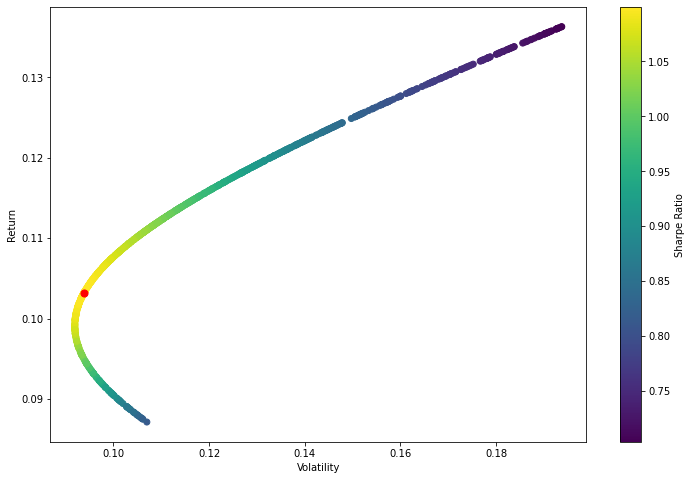

In [94]:
plt.figure(figsize=(12, 8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap="viridis")
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.scatter(max_sr_vol, max_sr_ret, c="red", s=50)
plt.show()

In [95]:
def get_ret_vol_sr(weights):
  weights = np.array(weights)
  ret = np.sum(log_return.mean()*weights* 252) 
  vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252, weights)))
  sr = ret / vol
  return np.array([ret, vol, sr])

def neg_sharpe(weights):
  return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
  return np.sum(weights)-1

In [96]:
cons = ({"type":"eq", "fun":check_sum})
bounds = ((0,1),(0,1))
init_guess = [0.25,0.25]

In [97]:
opt_results = minimize(neg_sharpe, init_guess, method="slsqp", bounds=bounds, constraints=cons)
print(opt_results)

     fun: -1.0996980281279072
     jac: array([-2.70158052e-05,  1.31577253e-05])
 message: 'Optimization terminated successfully.'
    nfev: 21
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.32732196, 0.67267804])


In [98]:
get_ret_vol_sr(opt_results.x)

array([0.10314615, 0.09379497, 1.09969803])

In [99]:
frontier_y = np.linspace(0, 0.2, 200)

In [100]:
def minimize_volatility(weights):
  return get_ret_vol_sr(weights)[1]

In [101]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

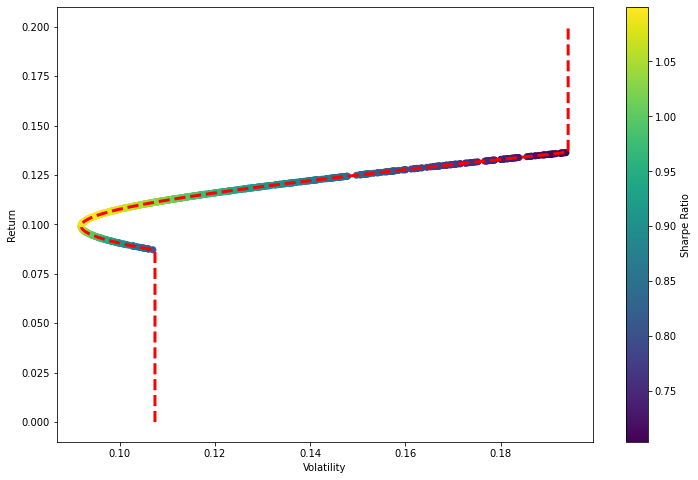

In [104]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.savefig('cover.png')
plt.show()